You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/seasonal-enso-subx-example.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/seasonal-enso-subx-example.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/subseasonal/seasonal-enso-subx-example.ipynb).

## Calculate Seasonal ENSO Skill of the NMME model NCEP-CFSv2

### In this example, we demonstrate: 
1. How to remotely access data from the North American Multi-model Ensemble (NMME) hindcast database and set it up to be used in `climpred`
2. How to calculate the Anomaly Correlation Coefficient (ACC) using seasonal data

### The North American Multi-model Ensemble (NMME)

Further information on NMME is available from {cite:t}`Kirtman2014` and the [NMME project website](https://www.cpc.ncep.noaa.gov/products/NMME/).

The NMME public database is hosted on the International Research Institute for Climate and Society (IRI) data server [http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/).

### Definitions

Anomalies
: Departure from normal, where normal is defined as the climatological value based on the average value for each month over all years.

Nino3.4
: An index used to represent the evolution of the El Nino-Southern Oscillation (ENSO). Calculated as the average sea surface temperature (SST) anomalies in the region 5S-5N; 190-240

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

<IPython.core.display.Javascript object>

In [3]:
def decode_cf(ds, time_var):
    """Decodes time dimension to CFTime standards."""
    if ds[time_var].attrs["calendar"] == "360":
        ds[time_var].attrs["calendar"] = "360_day"
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

<IPython.core.display.Javascript object>

The original monthly sea surface temperature (SST) hindcast data for the NCEP-CFSv2 model from IRIDL is a large dataset (~20GB). However, we can leverage `ingrid` on the IRIDL server and open server-side preprocessed data via `OpenDAP` into `xarray`. Averaging over longitude `X` and latitude `Y` and ensemble member `M` reduces the download size to just a few kB.

- [http://iridl.ldeo.columbia.edu/dochelp/topics/DODS/fnlist.html](http://iridl.ldeo.columbia.edu/dochelp/topics/DODS/fnlist.html)
- [https://iridl.ldeo.columbia.edu/dochelp/Documentation/funcindex.html?Set-Language=en](https://iridl.ldeo.columbia.edu/dochelp/Documentation/funcindex.html?Set-Language=en)

We take the ensemble mean here, since we are just using deterministic metrics in this example. `climpred` will automatically take the mean over the ensemble while evaluating metrics with `comparison="e2o"`, but this should make things more efficient so it doesn't have to be done multiple times.

In [4]:
%%time
# Get NMME data for NCEP-CFSv2, SST
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/X/190/240/RANGEEDGES/Y/-5/5/RANGEEDGES/[X%20Y%20M]average/dods'
fcstds = xr.open_dataset(url, decode_times=False)
fcstds = decode_cf(fcstds, 'S').compute()
fcstds

CPU times: user 62.9 ms, sys: 17.9 ms, total: 80.8 ms
Wall time: 800 ms


<xarray.Dataset>
Dimensions:  (S: 348, L: 10)
Coordinates:
  * S        (S) object 1982-01-01 00:00:00 ... 2010-12-01 00:00:00
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
Data variables:
    sst      (S, L) float64 26.36 26.63 27.15 27.96 ... 27.93 27.18 26.31 25.96
Attributes:
    Conventions:  IRIDL

<IPython.core.display.Javascript object>

The NMME data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`. `climpred` renames the dimensions based on their `attrs` `standard_name` when creating {py:class}`.HindcastEnsemble`, but we need to first adapt the coordinates manually.

In [5]:
fcstds = fcstds.rename({"S": "init", "L": "lead"})

<IPython.core.display.Javascript object>

Let's make sure that the `lead` dimension is set properly for `climpred`.  NMME data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization. We will change the `lead` to be integers starting with zero.

In [6]:
fcstds["lead"] = (fcstds["lead"] - 0.5).astype("int")

<IPython.core.display.Javascript object>

Next, we want to get the verification SST data from the data server

In [7]:
%%time
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/X/190/240/RANGEEDGES/Y/-5/5/RANGEEDGES/[X%20Y]average/dods'
verifds = decode_cf(xr.open_dataset(obsurl, decode_times=False),'T').compute()
verifds

CPU times: user 11.3 ms, sys: 9.96 ms, total: 21.2 ms
Wall time: 530 ms


<xarray.Dataset>
Dimensions:  (T: 405)
Coordinates:
  * T        (T) object 1982-01-16 00:00:00 ... 2015-09-16 00:00:00
Data variables:
    sst      (T) float64 26.81 26.78 27.26 28.06 ... 28.96 28.83 28.89 28.99
Attributes:
    Conventions:  IRIDL

<IPython.core.display.Javascript object>

Rename the dimensions to correspond to `climpred` dimensions.

In [8]:
verifds = verifds.rename({"T": "time"})

<IPython.core.display.Javascript object>

Convert the `time` data to be on the first of the month and in the same calendar format as the forecast output. The time dimension is natively decoded to start in February, even though it starts in January. It is also labelled as mid-month, and we need to label it as the start of the month to ensure that the dates align properly.

In [9]:
verifds["time"] = xr.cftime_range(
    start="1982-01", periods=verifds["time"].size, freq="MS", calendar="360_day"
)

<IPython.core.display.Javascript object>

Subset the data to 1982-2010

In [10]:
verifds = verifds.sel(time=slice("1982-01-01", "2010-12-01"))
fcstds = fcstds.sel(init=slice("1982-01-01", "2010-12-01"))

<IPython.core.display.Javascript object>

Make Seasonal Averages with `center=True` and drop `NaN`s.

In [11]:
f = (
    fcstds.rolling(lead=3, center=True)
    .mean()
    .dropna("lead")
    .isel(lead=slice(None, None, 3))
    .assign_coords(lead=np.arange(3))
)
o = verifds.rolling(time=3, center=True).mean().dropna(dim="time")

<IPython.core.display.Javascript object>

In [12]:
f["lead"].attrs = {"units": "seasons"}

<IPython.core.display.Javascript object>

Create a {py:class}`.HindcastEnsemble` object and {py:meth}`.HindcastEnsemble.verify` forecast skill.

In [13]:
hindcast = HindcastEnsemble(f).add_observations(o)
hindcast = hindcast.remove_seasonality("month")  # remove seasonal cycle

<IPython.core.display.Javascript object>

Compute the Anomaly Correlation Coefficient (ACC) {py:func}`.climpred.metrics._pearson_r` for 0, 1, and 2 season lead-times.

In [14]:
skillds = hindcast.verify(
    metric="acc", comparison="e2o", dim="init", alignment="maximize"
)
skillds

<xarray.Dataset>
Dimensions:  (lead: 3)
Coordinates:
  * lead     (lead) int64 0 1 2
    skill    <U11 'initialized'
Data variables:
    sst      (lead) float64 0.8466 0.7671 0.6785
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     348
    alignment:                     maximize
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           init
    reference:                     []

<IPython.core.display.Javascript object>

Text(0, 0.5, 'ACC')

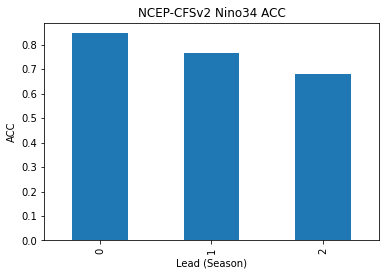

<IPython.core.display.Javascript object>

In [15]:
skillds.sst.to_series().plot(kind="bar")
plt.title("NCEP-CFSv2 Nino34 ACC")
plt.xlabel("Lead (Season)")
plt.ylabel("ACC")
plt.show()

### References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```